## Import libraries 🌏

In [ ]:
! pip install -qq ffmpeg

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

In [ ]:
import os, os.path
import librosa
import librosa.display
import copy
import warnings
import IPython
import cv2
import sklearn

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from collections import defaultdict
from PIL import Image
from uuid import uuid4
from sklearn.utils import shuffle

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
! pip install git+https://github.com/rwightman/pytorch-image-models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-wr09eyyx
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-wr09eyyx
  Created wheel for timm: filename=timm-0.6.2.dev0-py3-none-any.whl size=498066 sha256=4e626425a5aa4e343808a4eb6949bc2a236b953dc828a57499304deab738321d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pu7a29qx/wheels/a0/ec/5f/289118b747739bb1e02e36cf3d7e759721e881c183653719dc
Successfully built timm


In [ ]:
import timm

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
RANDOM_SEED = 2022

## Spectrograms for pretrain 🤩

In [ ]:
def read_spectrograms_helper(csv_path):
  spectrograms = pd.read_csv(csv_path)

  demo_img = Image.open(spectrograms.iloc[0].song_sample)
  plt.imshow(demo_img)
  plt.show()

  # spectrograms['class_label'] = spectrograms['bird'].astype('category').cat.codes

  return spectrograms

### Read ESC-50 spectrograms 🐷

In [ ]:
!gdown --id 1xKpJmF4qqB8kqd6azWihA2bqdBU52c48

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1xKpJmF4qqB8kqd6azWihA2bqdBU52c48
To: /content/melspectrogram_dataset_env.zip
100% 85.6M/85.6M [00:02<00:00, 36.9MB/s]


In [ ]:
!gdown --id 1wIPcVXbUqycqPMvpV62XFYXIUHg_1nqT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wIPcVXbUqycqPMvpV62XFYXIUHg_1nqT
To: /content/esc50_spectrograms.csv
100% 120k/120k [00:00<00:00, 79.9MB/s]


In [ ]:
!unzip -qq '/content/melspectrogram_dataset_env.zip' -d '/content'

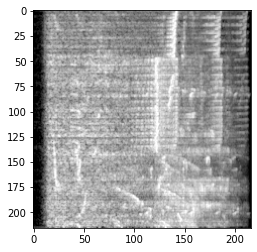

In [ ]:
env_spectrograms = read_spectrograms_helper('esc50_spectrograms.csv')

### Read AudioSet turkey spectrograms 🦃

In [ ]:
! gdown --id 1UwkkSVzUPalV6YNTqSCw6vsm2DeMYh0k

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UwkkSVzUPalV6YNTqSCw6vsm2DeMYh0k
To: /content/turkey_spectrograms.csv
100% 60.9k/60.9k [00:00<00:00, 75.3MB/s]


In [ ]:
! gdown --id 1v05091DGkUIFjAq9t7QqHI5nmJFvGFCv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1v05091DGkUIFjAq9t7QqHI5nmJFvGFCv
To: /content/melspectrogram_dataset_turkey.zip
100% 41.3M/41.3M [00:01<00:00, 29.3MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_turkey.zip' -d '/content'

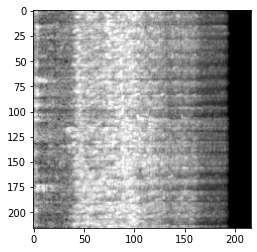

In [ ]:
turkey_spectrograms = read_spectrograms_helper('turkey_spectrograms.csv')

### Read AudioSet goose spectrograms 🧡

In [ ]:
! gdown --id 10Xqal_7wVFMSUh3uxLlHfuBzdvKYoLaX

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10Xqal_7wVFMSUh3uxLlHfuBzdvKYoLaX
To: /content/melspectrogram_dataset_goose.zip
100% 54.2M/54.2M [00:01<00:00, 31.6MB/s]


In [ ]:
! gdown --id 18chmCj0jhlVwjMwOxDm-Dbw7WHWl9Xn4

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18chmCj0jhlVwjMwOxDm-Dbw7WHWl9Xn4
To: /content/goose_spectrograms.csv
100% 78.0k/78.0k [00:00<00:00, 55.9MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_goose.zip' -d '/content'

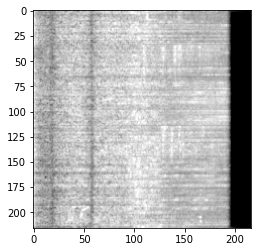

In [ ]:
goose_spectrograms = read_spectrograms_helper('goose_spectrograms.csv')

### Read AudioSet coo spectrograms 🕊

In [ ]:
! gdown --id 1JxfiWvzH2mj6npGPDshTFZbpvNcAk5n0

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JxfiWvzH2mj6npGPDshTFZbpvNcAk5n0
To: /content/melspectrogram_dataset_coo.zip
100% 52.1M/52.1M [00:01<00:00, 33.8MB/s]


In [ ]:
! gdown --id 1-1NckrjdP_JPL3QrAf4jeCEjlaIUG91U

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-1NckrjdP_JPL3QrAf4jeCEjlaIUG91U
To: /content/coo_spectrograms.csv
100% 72.3k/72.3k [00:00<00:00, 57.5MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_coo.zip' -d '/content'

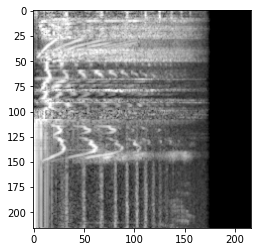

In [ ]:
coo_spectrograms = read_spectrograms_helper('coo_spectrograms.csv')

### Read AudioSet duck spectrograms 🦆

In [ ]:
! gdown --id 1ccMBJ7M0pfNX0__UhqvrgFmWcTIAAwPh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ccMBJ7M0pfNX0__UhqvrgFmWcTIAAwPh
To: /content/melspectrogram_dataset_duck.zip
100% 43.8M/43.8M [00:01<00:00, 29.4MB/s]


In [ ]:
! gdown --id 1-3toAVfwv4JM2Gn0kBJ9gwzSq7H-tjrL

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-3toAVfwv4JM2Gn0kBJ9gwzSq7H-tjrL
To: /content/duck_spectrograms.csv
100% 62.0k/62.0k [00:00<00:00, 78.2MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_duck.zip' -d '/content'

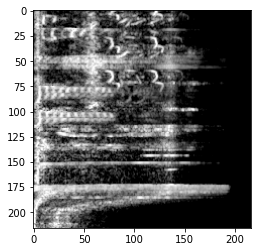

In [ ]:
duck_spectrograms = read_spectrograms_helper('duck_spectrograms.csv')

### Read AudioSet chicken spectrograms 🐔

In [ ]:
! gdown --id 17p3Urrbmg9uSX2bNB4opBx2HZ8fcBiS3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17p3Urrbmg9uSX2bNB4opBx2HZ8fcBiS3
To: /content/melspectrogram_dataset_chicken.zip
100% 50.9M/50.9M [00:01<00:00, 32.6MB/s]


In [ ]:
! gdown --id 1-5-kyr37kZ4wyRJ6OprFlDzNz6X4U984

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-5-kyr37kZ4wyRJ6OprFlDzNz6X4U984
To: /content/chicken_spectrograms.csv
100% 77.5k/77.5k [00:00<00:00, 80.1MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_chicken.zip' -d '/content'

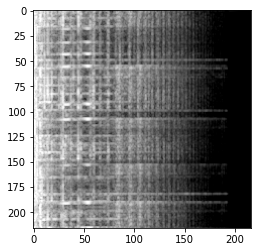

In [ ]:
chicken_spectrograms = read_spectrograms_helper('chicken_spectrograms.csv')

### Read AudioSet chirp spectrograms 🐣

In [ ]:
! gdown --id 18yqQCvxuH-1pDaBgf4fuv6SlrEmagh7M

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18yqQCvxuH-1pDaBgf4fuv6SlrEmagh7M
To: /content/melspectrogram_dataset_chirp.zip
100% 48.8M/48.8M [00:01<00:00, 30.3MB/s]


In [ ]:
! gdown --id 1-72rTzA1P6gLpxR03Mb921fhbCLFBhAh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-72rTzA1P6gLpxR03Mb921fhbCLFBhAh
To: /content/chirp_spectrograms.csv
100% 69.9k/69.9k [00:00<00:00, 58.7MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_chirp.zip' -d '/content'

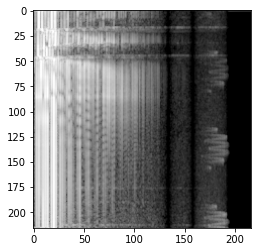

In [ ]:
chirp_spectrograms = read_spectrograms_helper('chirp_spectrograms.csv')

### Read AudioSet bird spectrograms 🐦

In [ ]:
! gdown --id 1N0K4GVncd3dXq23hGl3brqjsHzbUq7qT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1N0K4GVncd3dXq23hGl3brqjsHzbUq7qT
To: /content/melspectrogram_dataset_bird.zip
100% 5.91M/5.91M [00:00<00:00, 12.7MB/s]


In [ ]:
! gdown --id 1-Ah4GsRozNudmS-oc7twMYeO1pWu5hvI

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-Ah4GsRozNudmS-oc7twMYeO1pWu5hvI
To: /content/bird_spectrograms.csv
100% 8.45k/8.45k [00:00<00:00, 13.8MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_bird.zip' -d '/content'

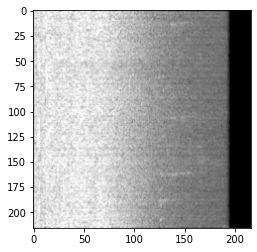

In [ ]:
bird_audioset_spectrograms = read_spectrograms_helper('bird_spectrograms.csv')

### Read AudioSet bird songs spectrograms 🎶

In [ ]:
! gdown --id 17ZDTWTtcrSgm_k11_4zRnvDxUJLSoipq

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17ZDTWTtcrSgm_k11_4zRnvDxUJLSoipq
To: /content/melspectrogram_dataset_song.zip
100% 50.4M/50.4M [00:01<00:00, 32.5MB/s]


In [ ]:
! gdown --id 1-HP-8YhKnVOCAxqg8bxlUDYzSG2X_HZw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-HP-8YhKnVOCAxqg8bxlUDYzSG2X_HZw
To: /content/song_spectrograms.csv
100% 70.8k/70.8k [00:00<00:00, 78.5MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_song.zip' -d '/content'

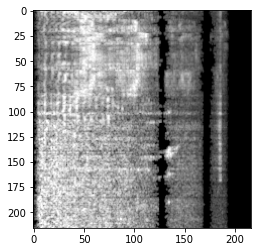

In [ ]:
bird_song_spectrograms = read_spectrograms_helper('song_spectrograms.csv')

### Read AudioSet pigeon spectrograms 💟

In [ ]:
! gdown --id 1XcKFbxyIGVmyxC288kh2v66LcDOzOVW6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XcKFbxyIGVmyxC288kh2v66LcDOzOVW6
To: /content/melspectrogram_dataset_pigeon.zip
100% 54.5M/54.5M [00:01<00:00, 30.0MB/s]


In [ ]:
! gdown --id 1-KuUlVNVae7m-bOVUMQE99JeB1MpWPWm

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-KuUlVNVae7m-bOVUMQE99JeB1MpWPWm
To: /content/pigeon_spectrograms.csv
100% 81.8k/81.8k [00:00<00:00, 83.8MB/s]


In [ ]:
! unzip -qq '/content/melspectrogram_dataset_pigeon.zip' -d '/content'

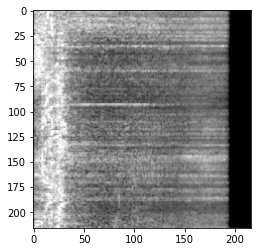

In [ ]:
pigeon_spectrograms = read_spectrograms_helper('pigeon_spectrograms.csv')

### Concatenate data 🤝

In [ ]:
pretrain_spectrograms = pd.concat([env_spectrograms,
                                   turkey_spectrograms,
                                   goose_spectrograms,
                                   coo_spectrograms,
                                   duck_spectrograms,
                                   chicken_spectrograms,
                                   chirp_spectrograms,
                                   bird_audioset_spectrograms,
                                   bird_song_spectrograms,
                                   pigeon_spectrograms])

In [ ]:
pretrain_spectrograms['class_label'] = pretrain_spectrograms['bird'].astype('category').cat.codes

In [ ]:
pretrain_spectrograms = shuffle(pretrain_spectrograms, random_state=RANDOM_SEED)

In [ ]:
amount_unique_pretrain = len(pretrain_spectrograms['bird'].unique())

In [ ]:
print(f'There are {amount_unique_pretrain} unique classes in pretrain')

There are 59 unique classes in pretrain


In [ ]:
fig = px.histogram(pretrain_spectrograms, x='bird', color='bird',
                   title='Classes distribution').update_xaxes(categoryorder="total descending")
fig.show()

### Split data 🐱

In [ ]:
paths_train_pretrain, paths_test_pretrain = train_test_split(pretrain_spectrograms, test_size=0.4, random_state=RANDOM_SEED)

In [ ]:
print(f'Train paths: {paths_train_pretrain.shape[0]}\nValidation paths: {paths_test_pretrain.shape[0]}')

Train paths: 5515
Validation paths: 3677


## Create Dataset 📚

In [ ]:
ENCODED_AUDIO = 'encoded_audio'
LABELS = 'labels'

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
class BirdsSongsDataset(torch.utils.data.Dataset):

  def __init__(self, audio_samples, labels):
    self.audio_samples = audio_samples
    self.labels = labels
  
  def __len__(self):
    return len(self.audio_samples)
  
  def __getitem__(self, index):
    label = self.labels[index]
    image = Image.open(self.audio_samples[index])
    image = transform(image)

    return (image, torch.tensor(label, dtype=torch.long))

In [ ]:
def create_data_loader(audio_paths, batch_size):
  ds = BirdsSongsDataset(
    audio_samples=audio_paths.song_sample.to_numpy(),
    labels=audio_paths.class_label.to_numpy(),
  )

  return torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=2)

In [ ]:
def get_data_loaders(paths_train, paths_test, batch_size):
  train_data_loader = create_data_loader(paths_train, batch_size)
  test_data_loader = create_data_loader(paths_test, batch_size)

  return train_data_loader, test_data_loader

In [ ]:
PRETRAIN_BATCH = 8

In [ ]:
train_data_loader_pretrain, test_data_loader_pretrain = get_data_loaders(paths_train_pretrain, 
                                                                         paths_test_pretrain,
                                                                         PRETRAIN_BATCH)

In [ ]:
pretrain_dataloaders_dict = {'train': train_data_loader_pretrain,
                               'val': test_data_loader_pretrain}

## Neural Network 🤖

### Helper functions 📋

In [ ]:
def plot_accuracy_scores(history):
  accuracy_scores = pd.DataFrame([history['train_acc'], history['val_acc']], index=['Train', 'Val']).T
  accuracy_scores['index'] = [i + 1 for i in range(accuracy_scores.shape[0])]

  accuracy_scores_melt = accuracy_scores.melt(id_vars='index', value_vars=['Train', 'Val'])
      
  fig = px.line(accuracy_scores_melt, 
                x='index', y='value', 
                title='Training history', 
                color='variable', labels={'value': 'Score', 'index': 'Epoch'})
  fig.show()

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    history = defaultdict(list)

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train().to(device)
            else:
                model.eval().to(device)

            running_loss = 0.0
            running_corrects = 0

            pred = []
            true = []

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)             

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = torch.flatten(labels)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                pred.extend(preds.view(-1).cpu().detach().numpy())
                true.extend(labels.view(-1).cpu().detach().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = balanced_accuracy_score(true, pred)

            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
            else:
                history['train_acc'].append(epoch_acc)

        print()

    print(f'Best val Acc: {best_acc}')

    model.load_state_dict(best_model_weights)
    return model, history

In [ ]:
def start_model_train_eval(model, dataloaders_dict, num_classes, num_epochs=5):
  model_ft = model.to(device)
  params_to_update = model.parameters()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
  return train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs)

In [ ]:
class Model(nn.Module):
    def __init__(self, name, num_classes):
        super(Model, self).__init__()
        self.model = timm.create_model(name, pretrained=True, in_chans=3)
        self.model.reset_classifier(num_classes=0) 
        in_features = self.model.num_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

### eca_nfnet_l0

In [ ]:
%%time
nfnet = Model(name='eca_nfnet_l0', num_classes=amount_unique_pretrain)

model_nfnet_pretrain, history_pretrain_nfnet = start_model_train_eval(
    nfnet,
    pretrain_dataloaders_dict, 
    amount_unique_pretrain,
    10)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l0_ra2-e3e9ac50.pth" to /root/.cache/torch/hub/checkpoints/ecanfnet_l0_ra2-e3e9ac50.pth


Epoch 1/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.69462192261713 Acc: 0.07483773593937981


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.5464737652492724 Acc: 0.19511143410771475

Epoch 2/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.4507464482136613 Acc: 0.22780253182186322


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.42873313701636245 Acc: 0.29623422828842183

Epoch 3/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.3086940821798781 Acc: 0.4323739878978643


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.33755968926307983 Acc: 0.4284485928983725

Epoch 4/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.2112108804608702 Acc: 0.5881279888050265


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.3518296103396033 Acc: 0.3992994032592189

Epoch 5/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.15789550074439995 Acc: 0.6731895109320891


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.3255500593182082 Acc: 0.44393315349591034

Epoch 6/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.11762822972243313 Acc: 0.75200311272461


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.26394365245796003 Acc: 0.5697315683924503

Epoch 7/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.09415593635356366 Acc: 0.8178460228437063


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.21941181822437802 Acc: 0.6044546254389023

Epoch 8/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.059089875636678516 Acc: 0.9091822309293377


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.22764226619965444 Acc: 0.6119986915368607

Epoch 9/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.052733774973115204 Acc: 0.9069284214431989


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.22102039731683773 Acc: 0.631978560632154

Epoch 10/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.031308503080165535 Acc: 0.9522216905734698


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.28981074309575516 Acc: 0.6262739470344466

Best val Acc: 0.631978560632154
CPU times: user 17min 23s, sys: 31.5 s, total: 17min 54s
Wall time: 19min 14s


In [ ]:
plot_accuracy_scores(history_pretrain_nfnet)

### convnext_tiny

In [ ]:
%%time
convnext = Model(name='convnext_tiny', num_classes=amount_unique_pretrain)

model_convnext_pretrain, history_pretrain_convnext = start_model_train_eval(
    convnext,
    pretrain_dataloaders_dict, 
    amount_unique_pretrain,
    10)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


Epoch 1/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.7692349166638688 Acc: 0.027689436894572265


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.6773862754118112 Acc: 0.03939516385041677

Epoch 2/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.6521731057598197 Acc: 0.04661814349364104


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.6410173251007896 Acc: 0.07847325654432544

Epoch 3/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.5933029801702251 Acc: 0.09431463793466323


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.592769776997915 Acc: 0.13391151067066007

Epoch 4/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.534911136601093 Acc: 0.16201556541908413


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.5577821974601543 Acc: 0.16558829254720764

Epoch 5/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.47854423066361046 Acc: 0.22516350298414714


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.5094930762427597 Acc: 0.21645467012558423

Epoch 6/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.41746902014174775 Acc: 0.30886840250104397


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.47831477617976265 Acc: 0.24866648303671146

Epoch 7/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.36459418910829217 Acc: 0.39648001777235514


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.4283304620587181 Acc: 0.33182784391498465

Epoch 8/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.31235618294774337 Acc: 0.4521324542067895


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.4064239804654459 Acc: 0.3781378575525342

Epoch 9/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.26195108987200383 Acc: 0.5443850133632988


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.34700393217263975 Acc: 0.4527436575410632

Epoch 10/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.2280869134667381 Acc: 0.6140547168871479


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 0.3438948418578114 Acc: 0.4714227237288511

Best val Acc: 0.4714227237288511
CPU times: user 27min 6s, sys: 1min 49s, total: 28min 56s
Wall time: 30min 5s


In [ ]:
plot_accuracy_scores(history_pretrain_convnext)

### resnest50d

In [ ]:
%%time
resnest = Model(name='resnest50d', num_classes=amount_unique_pretrain)

model_resnest_pretrain, history_pretrain_resnest = start_model_train_eval(
    resnest,
    pretrain_dataloaders_dict, 
    amount_unique_pretrain,
    10)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


Epoch 1/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 2.4131588902564234 Acc: 0.060847136650608084


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.033067591591701 Acc: 0.15015368095512713

Epoch 2/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 1.791424200152227 Acc: 0.23422269876508547


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 1.7753918279861023 Acc: 0.3686562048544892

Epoch 3/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 1.2016381522686181 Acc: 0.4928915501534716


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 1.8251514057442648 Acc: 0.4266967623210475

Epoch 4/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.7936716271657244 Acc: 0.6714102775000931


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.3065998038099225 Acc: 0.4168512018075191

Epoch 5/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.657228216066862 Acc: 0.7754587742620794


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.397619642185588 Acc: 0.5056743601717114

Epoch 6/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.5179357220206818 Acc: 0.8460033032452687


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.501645769150905 Acc: 0.5308830230336541

Epoch 7/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.3505351765268733 Acc: 0.9123269379514848


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.7314128345985402 Acc: 0.5093455263127845

Epoch 8/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.26424212868402247 Acc: 0.9480834073770101


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.634670903704106 Acc: 0.5693748338382926

Epoch 9/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.2035245806221949 Acc: 0.9505482056157335


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.809534606254065 Acc: 0.5775229941712398

Epoch 10/10
----------


  0%|          | 0/690 [00:00<?, ?it/s]

train Loss: 0.16883458040269633 Acc: 0.974798680529437


  0%|          | 0/460 [00:00<?, ?it/s]

val Loss: 2.8457009580299393 Acc: 0.5789012707881974

Best val Acc: 0.5789012707881974
CPU times: user 23min, sys: 4min 12s, total: 27min 12s
Wall time: 28min 25s


In [ ]:
plot_accuracy_scores(history_pretrain_resnest)

# Birds classification 🐦

### Read created spectrograms ⭐

In [ ]:
!gdown --id 1tKXJq4qVu-PmL9B2Fb1D3o0aHHB96evT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tKXJq4qVu-PmL9B2Fb1D3o0aHHB96evT
To: /content/melspectrogram_dataset.zip
100% 811M/811M [00:17<00:00, 47.0MB/s]


In [ ]:
!gdown --id 1eRS5s5xeselNjAywA7e_cEiJt8McrIQI

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eRS5s5xeselNjAywA7e_cEiJt8McrIQI
To: /content/birds_spectrograms.csv
100% 1.03M/1.03M [00:00<00:00, 151MB/s]


In [ ]:
!unzip -qq '/content/melspectrogram_dataset.zip' -d '/content'

In [ ]:
birds_spectrograms = pd.read_csv('birds_spectrograms.csv')

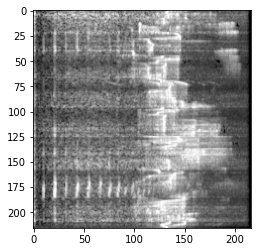

In [ ]:
demo_img = Image.open(birds_spectrograms.iloc[0].song_sample)
plt.imshow(demo_img)
plt.show()

In [ ]:
birds_spectrograms['class_label'] = birds_spectrograms['bird'].astype('category').cat.codes

In [ ]:
birds_spectrograms = shuffle(birds_spectrograms, random_state=RANDOM_SEED)

In [ ]:
birds_spectrograms.head(10)

,song_sample,bird,class_label
6304,melspectrogram_dataset/30038fac-f2f7-4fc9-9288...,grycat,12
9969,melspectrogram_dataset/e748933b-0a07-4548-8c6e...,normoc,19
10866,melspectrogram_dataset/3eb60866-7e6e-4c4b-a3c7...,rewbla,21
12571,melspectrogram_dataset/79cbfcc5-4661-4299-8f64...,spotow,23
3378,melspectrogram_dataset/2ffb1ce7-0af5-4fec-ae75...,comyel,7
3683,melspectrogram_dataset/d9ae9cd9-10bd-4d40-a2af...,comyel,7
8830,melspectrogram_dataset/cd8b68c7-a470-4a16-b63f...,norcar,18
13930,melspectrogram_dataset/cf7e79bb-30dd-4527-b72d...,wesmea,25
2589,melspectrogram_dataset/f7675ec0-866e-463b-8690...,comrav,5
9372,melspectrogram_dataset/75ba66d0-0874-46ae-a95e...,normoc,19


In [ ]:
amount_unique_birds = len(birds_spectrograms['bird'].unique())

In [ ]:
print(f'There are {amount_unique_birds} unique birds codes')

There are 26 unique birds codes


### Split Data 📌

In [ ]:
paths_train_birds, paths_test_birds = train_test_split(birds_spectrograms, test_size=0.3, random_state=RANDOM_SEED)

In [ ]:
print(f'Train paths: {paths_train_birds.shape[0]}\nValidation paths: {paths_test_birds.shape[0]}')

Train paths: 10110
Validation paths: 4333


## Load data 📖

In [ ]:
train_data_loader_birds, test_data_loader_birds = get_data_loaders(paths_train_birds, paths_test_birds, 100)

In [ ]:
birdssongs_dataloaders_dict = {'train': train_data_loader_birds,
                               'val': test_data_loader_birds}

## Neural network 👾

In [ ]:
def get_model_for_birds(model, num_classes):
  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, num_classes)
  return model

### eca_nfnet_l0

In [ ]:
model_nfnet_birds = get_model_for_birds(model_nfnet_pretrain, amount_unique_birds)

In [ ]:
%%time
model_nfnet_birds, history_birds_nfnet = start_model_train_eval(
    model_nfnet_birds,
    birdssongs_dataloaders_dict,
    amount_unique_birds,
    10)

Epoch 1/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 3.29030095835232 Acc: 0.13374109767827966


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 2.3315152825369396 Acc: 0.2761692644538911

Epoch 2/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.8283883213525238 Acc: 0.41054117380645694


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.5496988316042275 Acc: 0.4975068632133296

Epoch 3/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.2210665894884147 Acc: 0.6013799188559973


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.270610371005747 Acc: 0.5936230989305217

Epoch 4/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.8684104701483845 Acc: 0.719801596858976


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.1542994252066674 Acc: 0.6423529490312838

Epoch 5/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.6484458618636154 Acc: 0.787585406481045


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.9446564858322355 Acc: 0.7119652830480422

Epoch 6/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.5261518267700936 Acc: 0.8275282238533278


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8994852733094836 Acc: 0.7245281657588388

Epoch 7/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.44883216531352166 Acc: 0.8515020438020111


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8970480030413288 Acc: 0.7258622901318575

Epoch 8/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.3714155178428669 Acc: 0.8751580789344271


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7195674798215148 Acc: 0.7719715495449946

Epoch 9/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.26834794360145736 Acc: 0.9108913763624576


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8292309644864388 Acc: 0.7483087704906584

Epoch 10/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.23051705739680128 Acc: 0.9189795383452009


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7125263398166289 Acc: 0.790277059492655

Epoch 11/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.20824270910177192 Acc: 0.9314050505617294


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7631830105241221 Acc: 0.773621961295762

Epoch 12/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.15994123526426027 Acc: 0.9436561387474742


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7272920036959698 Acc: 0.7978342588746318

Epoch 13/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.11534944249367254 Acc: 0.9587140844839621


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7722447648517204 Acc: 0.7932675367667128

Epoch 14/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.11572824957348501 Acc: 0.9601411612455651


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.0624517208429949 Acc: 0.7372842178443733

Epoch 15/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.08946858684135772 Acc: 0.9721959344400429


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7083466233212321 Acc: 0.8188904067402947

Epoch 16/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.05024134516738457 Acc: 0.9840336179347209


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5933548678791664 Acc: 0.8488220040452352

Epoch 17/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.0321321323635812 Acc: 0.9903266057451344


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7484565743969738 Acc: 0.8370508106435584

Epoch 18/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.04048807220688941 Acc: 0.986542140945101


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7005694720944824 Acc: 0.841078716472894

Epoch 19/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.03436284350304639 Acc: 0.9891455193691716


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7365284735986439 Acc: 0.8366146869695347

Epoch 20/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.040825546938233016 Acc: 0.9864040988796332


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.6689670583460641 Acc: 0.8418665586470536

Best val Acc: 0.8488220040452352
CPU times: user 43min 19s, sys: 10min 37s, total: 53min 57s
Wall time: 55min


In [ ]:
plot_accuracy_scores(history_birds_nfnet)

### convnext_tiny

In [ ]:
model_convnext_birds = get_model_for_birds(model_convnext_pretrain, amount_unique_birds)

In [ ]:
%%time
model_convnext_birds, history_birds_convnext = start_model_train_eval(
    model_convnext_birds,
    birdssongs_dataloaders_dict,
    amount_unique_birds,
    10)

Epoch 1/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 3.4195554697431043 Acc: 0.09838081288031161


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 2.8911879194709957 Acc: 0.1534859991899801

Epoch 2/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 2.6788087084550414 Acc: 0.20022583718202897


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 2.51054946671395 Acc: 0.23723694392939088

Epoch 3/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 2.3298669251678725 Acc: 0.2866533446954227


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 2.2118077799763824 Acc: 0.3160466269994782

Epoch 4/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 2.032497406772289 Acc: 0.3711689814751846


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.9465951515129964 Acc: 0.39406750026823184

Epoch 5/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.7697230064550564 Acc: 0.45241101866561456


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.7155550292422472 Acc: 0.46784103293270946

Epoch 6/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.5436749127863894 Acc: 0.5227172894536761


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.511789812162405 Acc: 0.53867039301588

Epoch 7/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.3497606981195636 Acc: 0.5851467155779009


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.3447189172585843 Acc: 0.596408439162764

Epoch 8/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.186471259131158 Acc: 0.6350089565197787


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.2234979888018906 Acc: 0.6340125749488836

Epoch 9/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.046870028922513 Acc: 0.6809170228530371


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.1313279701550287 Acc: 0.6583500432035035

Epoch 10/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.9253574212023695 Acc: 0.7209918261377981


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.0526009105023848 Acc: 0.6820155991780636

Epoch 11/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.8218337414983354 Acc: 0.758436815328487


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.969935658510139 Acc: 0.7058575446376769

Epoch 12/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.7307349639206859 Acc: 0.7827262848206137


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.9158388884656842 Acc: 0.7220897500900885

Epoch 13/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.6528936206233253 Acc: 0.809841742820286


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8771524237562981 Acc: 0.73316905137337

Epoch 14/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.5912405516838048 Acc: 0.8280919072648236


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8408233581831734 Acc: 0.7381601273892678

Epoch 15/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.5324948813423559 Acc: 0.8473483885634364


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8149098011794224 Acc: 0.7500443725585735

Epoch 16/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.47641916066577655 Acc: 0.8665705046174769


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8161865409240969 Acc: 0.7538065482795158

Epoch 17/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.4337806735080911 Acc: 0.8793622218736821


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.8150309294001379 Acc: 0.7593400532104597

Epoch 18/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.39344964443192876 Acc: 0.8898871663242438


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7993406308266794 Acc: 0.765772369109653

Epoch 19/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.35532656563842036 Acc: 0.9022503431257065


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7657485493825705 Acc: 0.7732641530057853

Epoch 20/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.3175341381574405 Acc: 0.9169150827625313


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7335602059915658 Acc: 0.7851987488264831

Best val Acc: 0.7851987488264831
CPU times: user 2h 32min 41s, sys: 19min 34s, total: 2h 52min 16s
Wall time: 2h 52min 37s


In [ ]:
plot_accuracy_scores(history_birds_convnext)

### resnest50d

In [ ]:
model_resnet_birds = get_model_for_birds(model_resnest_pretrain, amount_unique_birds)

In [ ]:
%%time
model_resnet_birds, history_birds_resnest = start_model_train_eval(
    model_resnet_birds,
    birdssongs_dataloaders_dict,
    amount_unique_birds,
    20)

Epoch 1/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 2.5039886555733006 Acc: 0.24359784522111882


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.8469229709075885 Acc: 0.4392003438283571

Epoch 2/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 1.4414468994833949 Acc: 0.5577255386835811


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 1.2225658946958393 Acc: 0.6415178989607864

Epoch 3/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.933794025674418 Acc: 0.7168957816317676


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.9505906872074735 Acc: 0.7146615512113189

Epoch 4/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.6273134917197666 Acc: 0.8176537783437537


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.7735987905951974 Acc: 0.773769485035702

Epoch 5/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.41183019239495994 Acc: 0.8849116568642074


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.6593105117580838 Acc: 0.801113644667415

Epoch 6/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.26079270976358837 Acc: 0.9303902931151016


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5996462805783421 Acc: 0.8174691558475341

Epoch 7/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.16229931709036954 Acc: 0.9635089836910862


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.565839202511869 Acc: 0.8295631679143057

Epoch 8/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.10024370200301932 Acc: 0.9807118045345594


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5492287965561483 Acc: 0.8362256284667642

Epoch 9/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.06315632039657126 Acc: 0.9894460281576032


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.54111160717246 Acc: 0.8366524070748458

Epoch 10/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.04141814940867892 Acc: 0.9951471637945521


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5421477264189264 Acc: 0.8397650489698429

Epoch 11/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.028487821729553442 Acc: 0.9978545685552435


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.545490560054559 Acc: 0.8418570864673056

Epoch 12/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.020241616566460046 Acc: 0.9988754967472381


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5508456034003354 Acc: 0.8440841191113274

Epoch 13/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.01515524359498243 Acc: 0.9994110347756346


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5565549656972306 Acc: 0.8459740665881639

Epoch 14/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.011631046925025645 Acc: 0.9998133085177271


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5625859743696477 Acc: 0.8458388806547477

Epoch 15/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.009305489237782289 Acc: 0.9999213465471134


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5672653287876128 Acc: 0.8466660813239739

Epoch 16/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.0077067458397376285 Acc: 0.9999213465471134


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5718185455948217 Acc: 0.8468661219909829

Epoch 17/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.006532348325438282 Acc: 1.0


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.576049300558485 Acc: 0.8470934561045698

Epoch 18/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.005635630814833005 Acc: 1.0


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5799710168977161 Acc: 0.8472420623838294

Epoch 19/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.004935918135649565 Acc: 1.0


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5836644281340669 Acc: 0.8470711222128892

Epoch 20/20
----------


  0%|          | 0/102 [00:00<?, ?it/s]

train Loss: 0.004377887306069821 Acc: 1.0


  0%|          | 0/44 [00:00<?, ?it/s]

val Loss: 0.5871281991950255 Acc: 0.8462338830106196

Best val Acc: 0.8472420623838294
CPU times: user 49min 31s, sys: 20min 59s, total: 1h 10min 30s
Wall time: 1h 11min 32s


In [ ]:
plot_accuracy_scores(history_birds_resnest)

In [ ]:
torch.save(model_resnet_birds.state_dict(), 'resnet_birds.pt')